# Online Phase: PBDW

**Aim of this tutorial:** learn how the PBDW algorithm behaves works, how the reconstruction is influenced by the presence of random noise. This formulation acts as a general framework for the fusion between measures and models, in a data assimilation framework. This notebook shows how to test the method on a set of test snapshots.


----

*To execute this notebook* it is necessary to have the snapshots stored in `Snapshots` folder, placed in this directory (otherwise modify `path_FOM` variable) and the basis functions (POD modes in this case) and sensors (SGREDDY in this case) in the `Offline_results` folder.

In [1]:
import numpy as np
from IPython.display import clear_output

from dolfinx.fem import FunctionSpace

from pyforce.tools.write_read import ImportH5
from pyforce.tools.functions_list import FunctionsList

import matplotlib.pyplot as plt
from matplotlib import cm

path_off ='./Offline_results/'

The geometry is imported from "ANL11A2_octave.geo", generated with GMSH. Then, the mesh is created with the gmsh module.

In [2]:
from neutronics import create_anl11a2_mesh

domain, _, _ = create_anl11a2_mesh(use_msh=True, save_mesh=False)

fuel1_marker    = 1
fuel2_marker    = 2
fuel_rod_marker = 3
refl_marker     = 4

void_marker     = 10
sym_marker      = 20

clear_output()

## Importing Snapshots

The snapshots are loaded and stored into suitable data structures. The snapshots live in a functional space: piecewise linear functions.

In [3]:
V = FunctionSpace(domain, ("Lagrange", 1))

Defining the variables to load.

In [4]:
var_names = [
             'phi_1',
             'phi_2'
             ]

tex_var_names = [
                 r'\phi_1',
                 r'\phi_2'
                 ]


Let us load the test snapshots.

In [5]:
path_FOM = './Snapshots/'

test_snaps = list()

for field_i in range(len(var_names)):
    test_snaps.append(FunctionsList(V))

    tmp_FOM_list, _ = ImportH5(V, path_FOM+'test_snap_'+var_names[field_i], var_names[field_i])
    
    for mu in range(len(tmp_FOM_list)):
        test_snaps[field_i].append(tmp_FOM_list(mu))
    
    del tmp_FOM_list      

Let us import the basis functions (POD modes) and sensors (SGREEDY, considering only the Riesz representation in $H^1$).

In [6]:
bf = dict()

for field_i in range(len(var_names)):
    
    bf[var_names[field_i]] = ImportH5(V, path_off+'/BasisFunctions/basisPOD_'+var_names[field_i], 'POD_'+var_names[field_i])[0]
    
s = 2.

is_H1 = True
fun_space_label = 'H1'

bs = dict()

for field in var_names:
    bs[field]  = ImportH5(  V, 
                            path_off+'/BasisSensors/sensorsSGREEDYPOD_' + field+'_s_{:.2e}_'.format(s)+fun_space_label,
                            'SGREEDYPOD_' +field+'_s_{:.2e}'.format(s))[0]

## Online Reconstruction

In this section, the potentialities of PBDW are analysed: focusing on the effect of random noise.



###  Effect of random noise
The measures are polluted by synthetic random noise (modelled as uncorrelated Gaussian noise)
\begin{equation*}
\{y_m = v_m(u)+\epsilon_m\}_{m=1}^M \qquad \text{ with }\epsilon_m \sim \mathcal{N}(0,\sigma^2)
\end{equation*}

The PBDW is implemented in `PBDW` class, requiring as input the basis functions, basis sensors, the name of the field to reconstruct and the flag to choose the Riesz representation space.


In [7]:
from pyforce.online.pbdw_synthetic import PBDW

pbdw_online = dict()

for field in var_names:
    pbdw_online[field] = PBDW(  bf[field],
                                bs[field],
                                field, is_H1=is_H1)

The measures are polluted by synthetic random noise (modelled as uncorrelated Gaussian noise)
\begin{equation*}
\{y_m = v_m(u)+\epsilon_m\}_{m=1}^M \qquad \text{ with }\epsilon_m \sim \mathcal{N}(0,\sigma^2)
\end{equation*}
In this section, the test errors will be computed as
\begin{equation*}
\begin{split}
E_M[u] &= \left\langle \left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_M[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}\right\rangle_{\boldsymbol{\mu}\in\Xi^{test}}\\
\varepsilon_M[u] &= \left\langle \frac{\left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_M[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}}{\left\| u(\cdot;\,\boldsymbol{\mu}) \right\|_{L^2(\Omega)}}\right\rangle_{\boldsymbol{\mu}\in\Xi^{test}}
\end{split}
\end{equation*}
given $\mathcal{P}_M[u]$ the reconstruction operator with $M$ magic functions.

This operation is done with the `synt_test_error` method of PBDW class: the output is composed by the test errors and the computational times needed for the reconstruction.  The PBDW method needs the test snapshots, the dimension of the background space, spanned by the POD modes, the maximum number of sensors to use, the value of random noise (if `None` so pollution of the measures is implemented).

In [8]:
noise_value = [None, 1e-3, 2.5e-2]

Nmax = 10
Mmax = 20

test_errors = dict()
comput_time = dict()

print('----------------------------')
for field_i, field in enumerate(var_names):
    print('Reconstructing '+field)
    test_errors[field] = list()
    comput_time[field] = list()
    
    for kk, noise in enumerate(noise_value):
        print('     noise = '+str(noise))
            
        out = pbdw_online[field].synt_test_error(test_snaps[field_i], 
                                                 N=Nmax, M = Mmax,
                                                 noise_value = noise)

        test_errors[field].append(np.zeros((2, Mmax-Nmax+1)))
        test_errors[field][kk][0] = out[0][:]
        test_errors[field][kk][1] = out[1][:]
        comput_time[field].append(out[2])
        del out
                
    print('----------------------------')

----------------------------
Reconstructing phi_1
     noise = None
     noise = 0.001
     noise = 0.025
----------------------------
Reconstructing phi_2
     noise = None
     noise = 0.001
     noise = 0.025
----------------------------


The PBDW formulation includes also an hyperparameter $\xi$, which should be tuned properly as in [Maday and Taddei (2019)](https://epubs.siam.org/doi/10.1137/18M116544X) if the noise value increases too much. The method `synt_test_error` has an optional parameter `reg_param` to set the value of $\xi$.

Let us plot the test error, to observe the instability of the GEIM algorithm with respect to random noise (i.e., the error increases as the noise level increases). A helper function is introduced to focus on the results.

In [9]:
def plot_errors(test_errors, Nmax, Mmax, sigma, var_names, tex_var_names):
    ls = 2
    Mplot = np.arange(Nmax, Mmax+1,1)

    fig, axs = plt.subplots(nrows = 2, ncols = len(var_names), sharex = True, figsize = (6 * len(var_names), 5 * 2))

    colors = cm.jet(np.linspace(0.,0.9,len(sigma)))
    
    for err in range(2):
        for idx_noise in range(len(sigma)):
            if sigma[idx_noise] is None:
                label = r'No Noise'
            else:
                label = r'$\sigma = 10^{'+str(int(np.log10(sigma[idx_noise])))+'}$'
            
            for field_i, field in enumerate(var_names):
                axs[err, field_i].semilogy( Mplot, test_errors[field][idx_noise][err],         
                                            linewidth=ls, c = colors[idx_noise], label = 'PBDW - '+label)
                
    for ax in axs.flatten():
        ax.grid(which = 'major', linestyle = '-')
        ax.grid(which = 'minor', linestyle = '--')
        ax.set_xlim(Nmax, Mmax)
    
    for field_i in range(len(var_names)):            
        axs[-1,field_i].set_xlabel(r'Number of Measures $M$', fontsize=25)

        axs[0,field_i].set_ylabel(r'Absolute Error $E_M['+tex_var_names[field_i]+']$', fontsize=25)
        axs[1,field_i].set_ylabel(r'Relative Error $\epsilon_M['+tex_var_names[field_i]+']$', fontsize=25)
        
    Lines, Labels = axs[0,0].get_legend_handles_labels()

    fig.legend(Lines, Labels, framealpha=1, loc=(0.02, 0.91), ncols = len(sigma), fontsize=20)
    fig.subplots_adjust(hspace = 0.05, wspace = 0.3, top = 0.875)
    
    plt.show()

The function is used to plot the test error for different values of random noise $\sigma$.

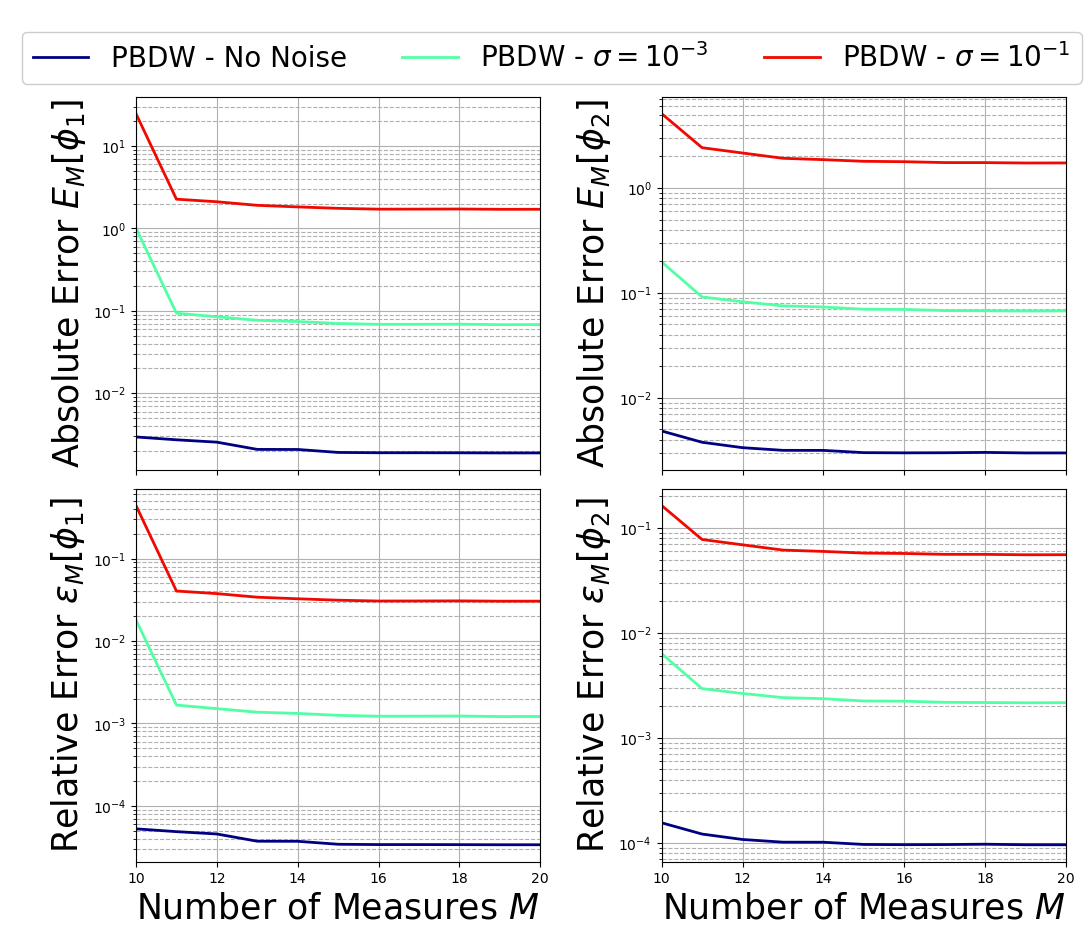

In [10]:
plot_errors(test_errors, Nmax, Mmax, noise_value, var_names, tex_var_names)

The important thing to observe is that the PBDW algorithm is stabel in presence of random noise!

The computational times have been saved in the dictionary `comput_time` for each algorithm, each entry is another dictionary for each field, and each element is a list for every value of noise: the keys for this variable are `Measure` (time to get the local data), `LinearSystem` (time to solve the linear system), `Errors` (time to compute the test error with respect to the high-fidelity solution).

In [11]:
comput_time['phi_1'][0].keys()

dict_keys(['Measure', 'LinearSystem', 'Errors'])

Let us plot the computational time required by the Online Phase using this helper function.

In [12]:
def plot_comput_times(comput_time, idx_noise, var_names, tex_var_names, s, sigma):

    # Initialize subplots
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 5))


    for idx_ax in range(len(axs)):
        
        # Iterate over field_i values
        colors = plt.cm.viridis(np.linspace(0.4, 0.8, len(var_names)))  # Choose a colormap
        for field_i, color in zip(range(len(var_names)), colors):
            means = []
            stds = []
            field = var_names[field_i]

            # Calculate mean and std for each key
            for key in list(comput_time[field][idx_noise].keys()):
                mean = np.mean(np.mean(comput_time[field][idx_noise][key], axis=0))
                std = np.std(np.mean(comput_time[field][idx_noise][key], axis=0))
                means.append(mean)
                stds.append(std)

            # Plot the bar chart with error bars for standard deviation
            bar_width = 0.2  # Adjust as needed
            ind = np.arange(len(list(comput_time[field][idx_noise].keys())))
            bars = axs[idx_ax].bar(ind + (field_i - len(var_names) / 4) * bar_width, means, bar_width, label=r'$'+tex_var_names[field_i]+'$', color=color, yerr=stds, capsize=5)
        
            axs[idx_ax].set_ylabel(r'CPU Time (s)', fontsize=20)
            axs[idx_ax].set_title(r'PBDW - $s={:.2f}$'.format(s)+' and $\sigma= 10^{'+str(int(np.log10(sigma[idx_noise])))+'}$', fontsize=20)
            
        axs[idx_ax].set_xticks(ind)
        axs[idx_ax].set_xticklabels(list(comput_time[field][idx_noise].keys()))
        axs[idx_ax].legend(framealpha=1, fontsize=20)
        axs[idx_ax].tick_params(axis='both', labelsize=18)
        axs[idx_ax].grid()
        
    plt.tight_layout()

Only a single value of noise will be plotted for the sake of clarity.

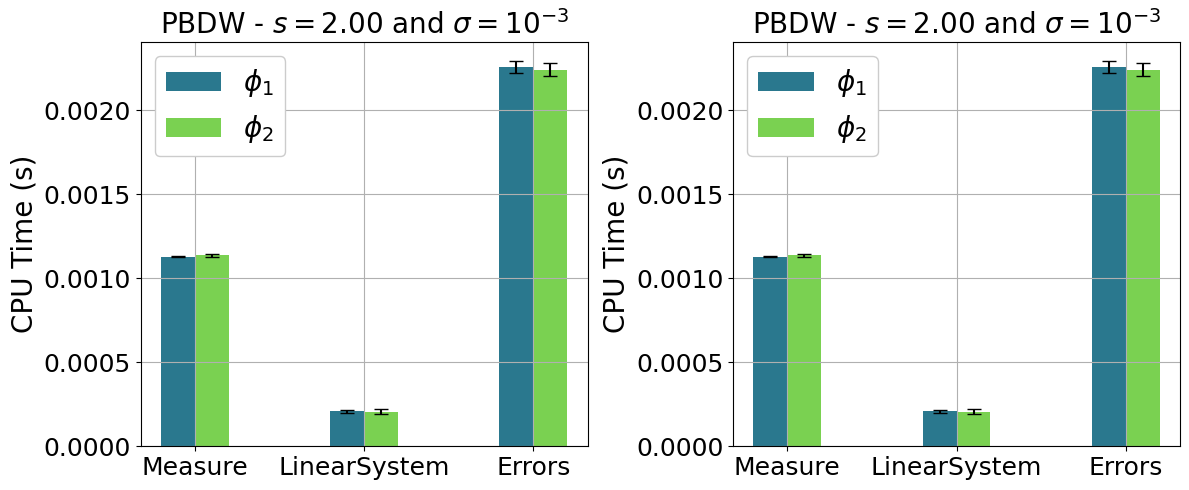

In [13]:
plot_comput_times(comput_time, 1, var_names, tex_var_names, s, noise_value)

### Plotting the interpolant and the residual fields
Using *pyvista* and some additional functions the interpolant and its residual field $r[u] = | u - \mathcal{P}[u]|$ is plotted.

Let us reconstruct one of the fields for the whole test set, using some functions of the *PBDW* class: adopting the `reconstruct` method for all the snapshot of the test set, they need the snapshot, the number of sensors to use, the noise value and the `reg_param` for the `TRGEIM` class. The first output of this method is the reconstructed field.

In [14]:
Mmax = 20

noise_value = 1e-2

rom_recs = list()

for field_i, field in enumerate(var_names):
    rom_recs.append({'PBDW': FunctionsList(V)})

    for mu in range(len(test_snaps[field_i])):
            
        out = pbdw_online[field].reconstruct(   test_snaps[field_i](mu), 
                                                N = Nmax, M = Mmax, noise_value = noise_value)
        rom_recs[field_i]['PBDW'].append(out[0])
        del out

Let us use the `plot_FOM_vs_ROM` from `contour_plotting.py` to create contour plots, this function require the reconstructed field to be a dictionary to make subplots

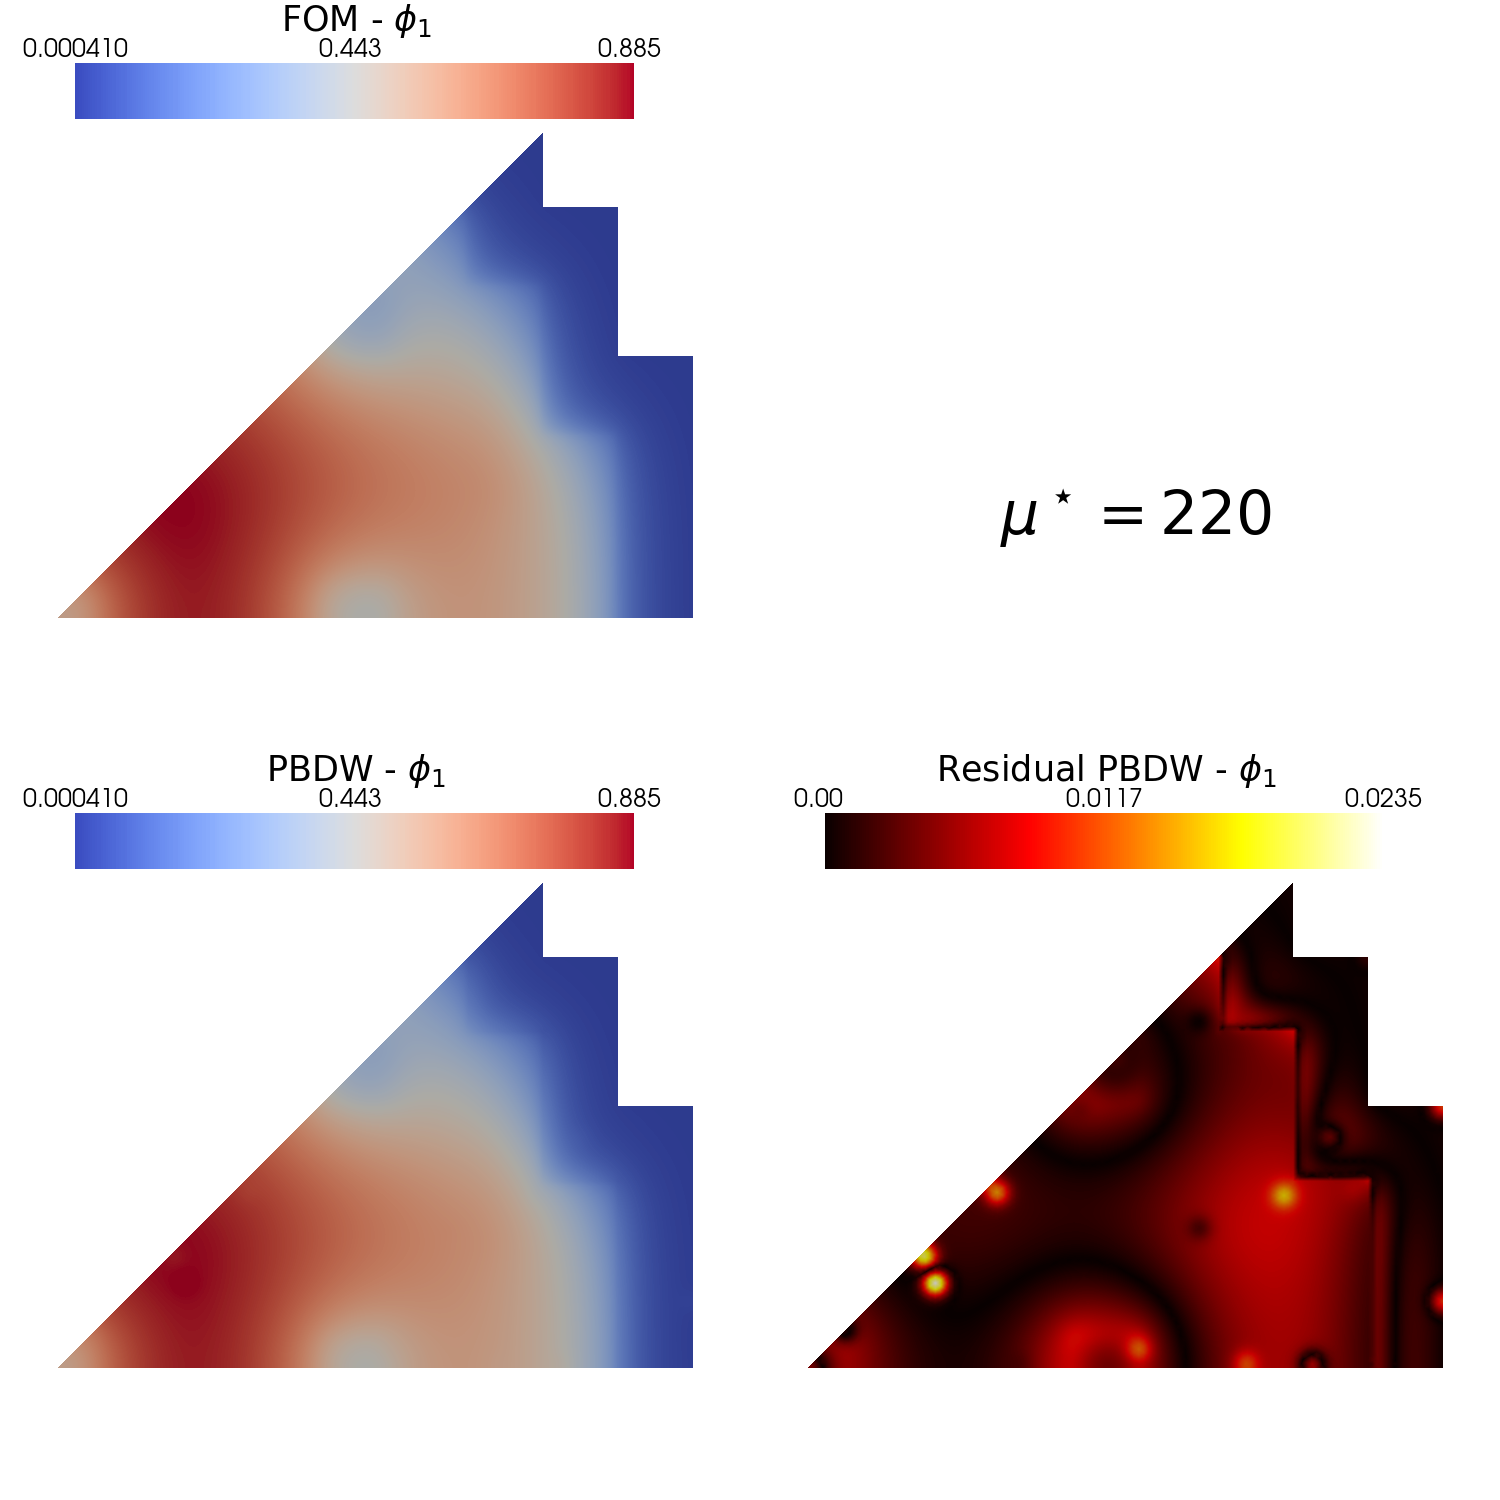

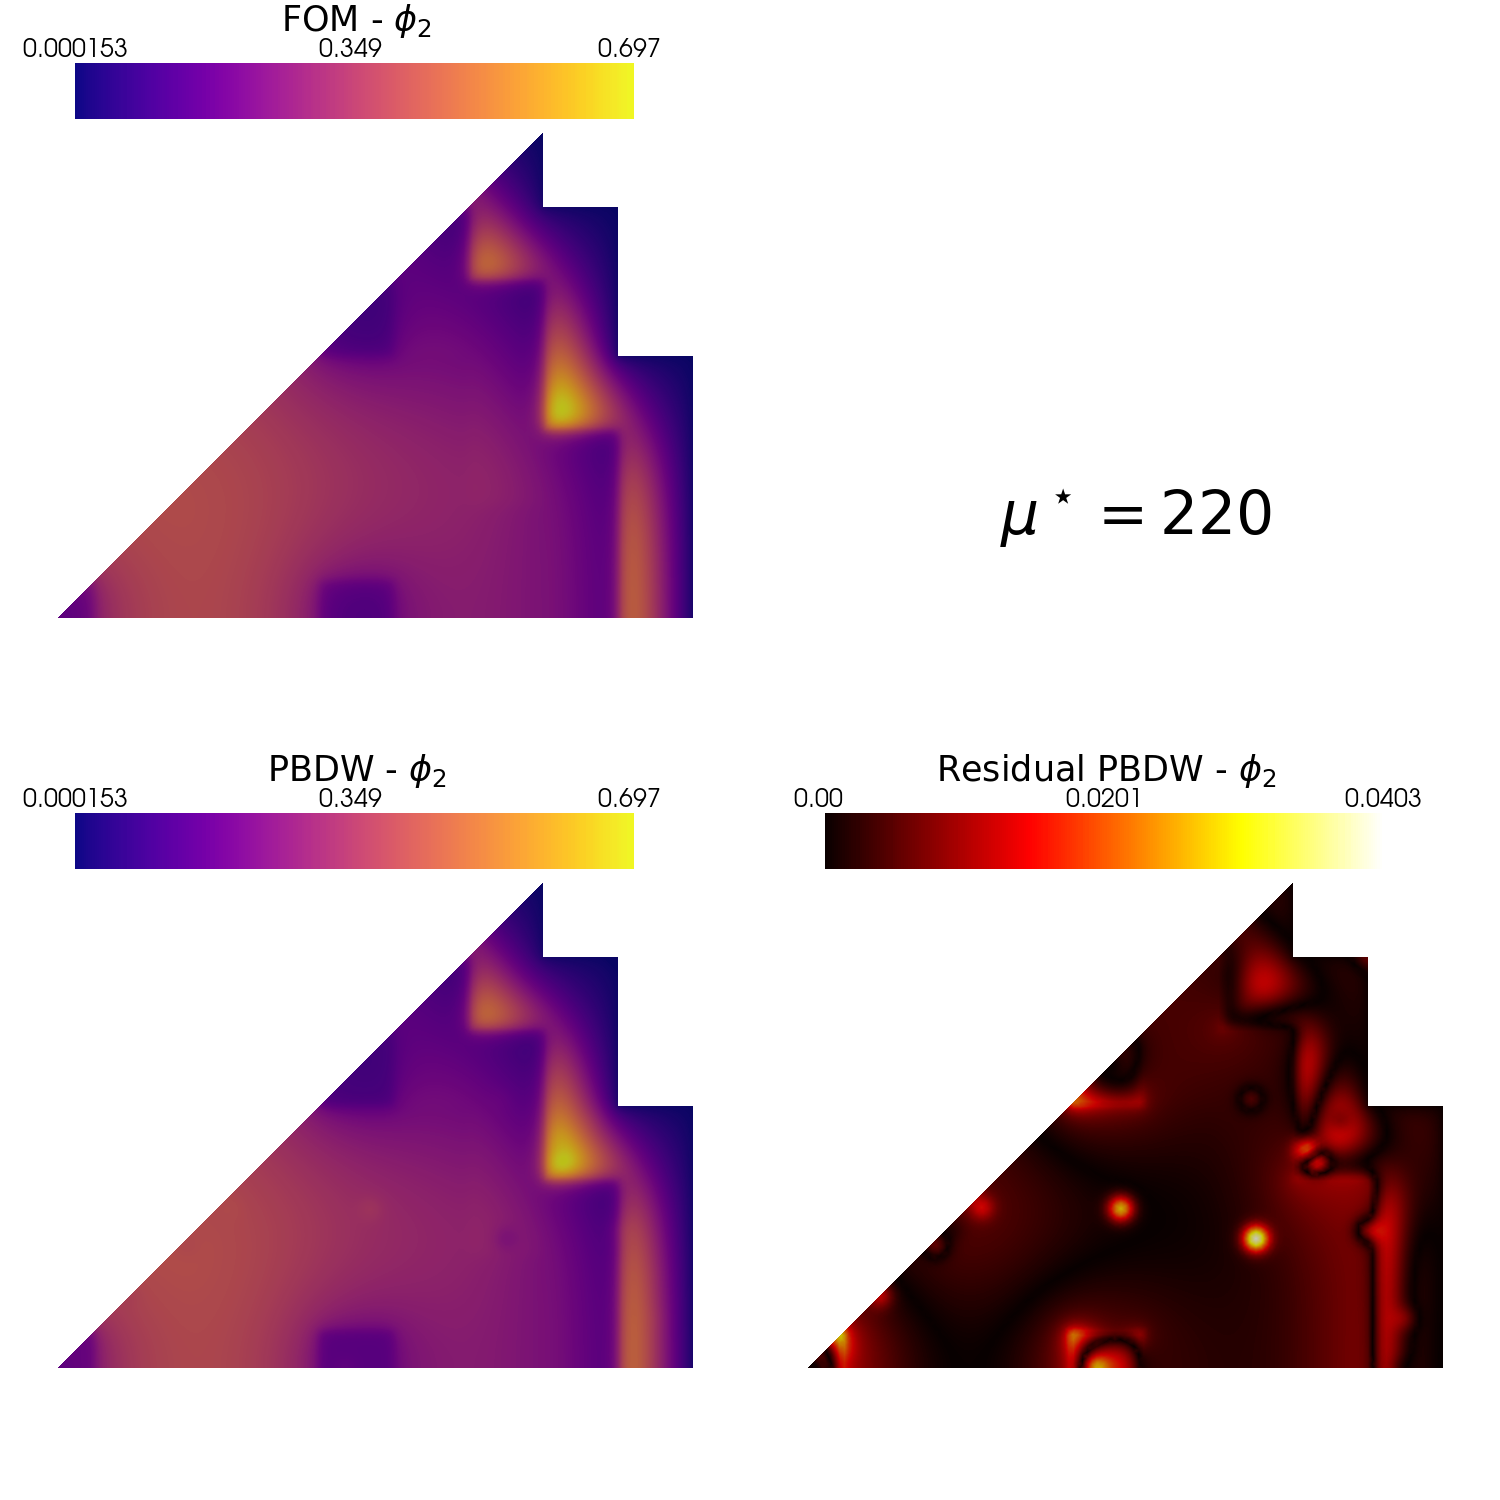

In [15]:
from contour_plotting import plot_FOM_vs_ROM

mu_to_plot = 220

plot_FOM_vs_ROM(test_snaps[0], rom_recs[0], mu_to_plot, 
                title=r'$\mu^\star='+str(mu_to_plot)+'$', varname=tex_var_names[0], 
                _resolution = [750,750], zoom = 1.1, position_cb=[0.1, 0.84],
                colormap=cm.coolwarm, colormap_res=cm.hot)

plot_FOM_vs_ROM(test_snaps[1], rom_recs[1], mu_to_plot, 
                title=r'$\mu^\star='+str(mu_to_plot)+'$', varname=tex_var_names[1], 
                _resolution = [750,750], zoom = 1.1, position_cb=[0.1, 0.84],
                colormap=cm.plasma, colormap_res=cm.hot)

Let us compare the fast and thermal flux with respect to some benchmark data. We are going to use the `extract_cells` function to extract the values of the fields on a specific lines.

In [16]:
from contour_plotting import extract_cells

Nhplot = 1000
xMax = 170
x_line = np.linspace(0, xMax + 1e-20, Nhplot)
points = [np.zeros((3, Nhplot)), 
          np.zeros((3, Nhplot))]
points[0][0] = x_line
points[1][0] = x_line
points[1][1] = x_line

extracted = [extract_cells(domain, point) for point in points]

Among the test snapshots there is one belonging to a neutronic benchmark, the results of the PBDW algorithm will be compared with the high-fidelity solution and the benchmark data.

In [17]:
import pandas as pd

bench_path = '..//BenchmarkData/MGDiffusion_ANL11A2/anl11a2_data.xlsx'

bench_data = [pd.read_excel(bench_path, sheet_name='x-axis').to_numpy()/1000, 
              pd.read_excel(bench_path, sheet_name='Diagonal').to_numpy()/1000]

bench_labels = [r'$y=x$', r'$y=0$']

Let us make a plot over lines for the fast and thermal fluxes.

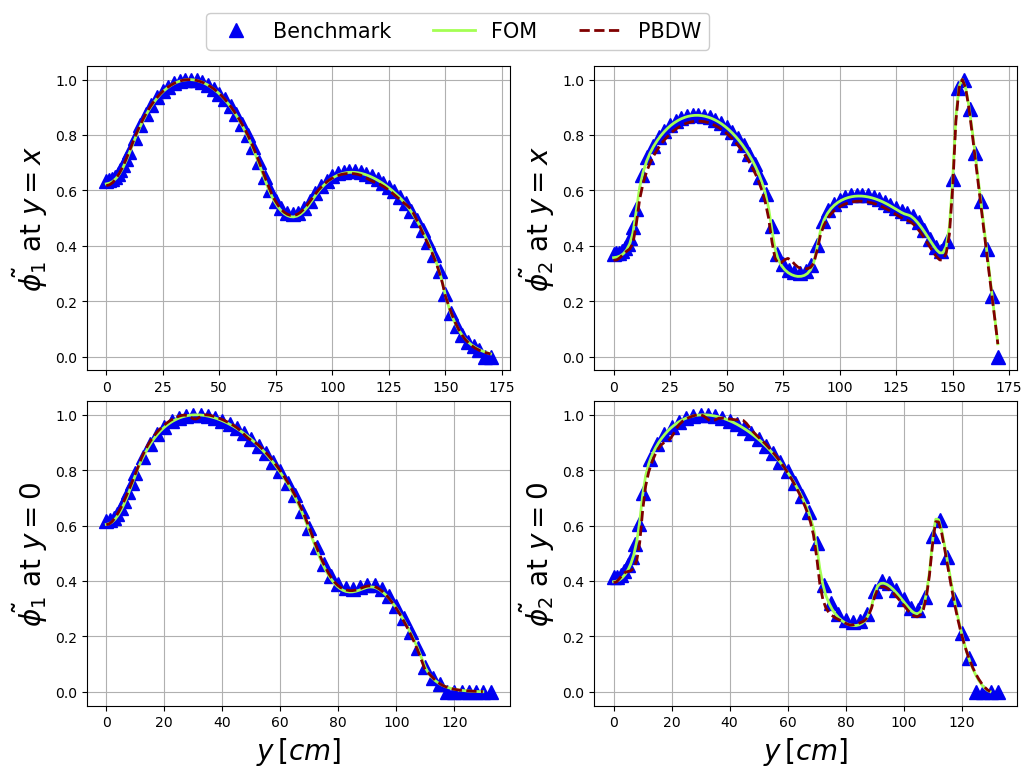

In [18]:
mark_size = 10
ls = 2
tickssize = 20

mu_bench = 220

fluxFigure, axs = plt.subplots(nrows = 2, ncols = len(var_names), figsize=(6 * len(var_names), 8))

for bench_i in range(2):
    xPlot = extracted[bench_i][0]
    cells = extracted[bench_i][1]
    for field_i in range(len(var_names)):
        colors = cm.jet(np.linspace(0.1,1, len(list(rom_recs[field_i].keys()))+2))
        axs[bench_i, field_i].plot(bench_data[bench_i][:, 0], bench_data[bench_i][:, field_i+bench_i+1] / max(bench_data[bench_i][:, field_i+bench_i+1]), '^', 
                                   c=colors[0], label = r'Benchmark', markersize=mark_size)
        axs[bench_i, field_i].plot(xPlot[:,0], test_snaps[field_i].map(mu_bench).eval(xPlot, cells) / max(test_snaps[field_i].map(mu_bench).eval(xPlot, cells)),
                                   c=colors[1], label = r'FOM', linewidth=ls)
        
        for algo_i, algo in enumerate(list(rom_recs[field_i].keys())):
            axs[bench_i, field_i].plot(xPlot[:,0], rom_recs[field_i][algo].map(mu_bench).eval(xPlot, cells) / max(rom_recs[field_i][algo].map(mu_bench).eval(xPlot, cells)),
                                       '--', c=colors[2+algo_i], label = algo, linewidth=ls)
            

        axs[bench_i, field_i].grid(which='major',linestyle='-')
        axs[bench_i, field_i].grid(which='minor',linestyle='--')
        axs[bench_i, field_i].set_ylabel(r"$\tilde{"+tex_var_names[field_i]+"}$ at "+bench_labels[bench_i], fontsize=20)
        
        if bench_i + 1 == 2:
            axs[bench_i, field_i].set_xlabel(r"$y\,[cm]$",fontsize=20)    
        
Lines, Labels = axs[0,0].get_legend_handles_labels()
fluxFigure.legend(Lines, Labels, framealpha=1, loc=(0.2, 0.935), ncols = 2+len(rom_recs[0]), fontsize=15)
fluxFigure.subplots_adjust(wspace=0.2, hspace=0.1, top = 0.91)